### Creación activo hedge  

En este notebook se utilizan los alphas anualizados de los activos para encontrar el mejor activo para utilizarlo como hedge en la estrategia VIXSI con SPY.

Como lo que interesa es mejorar al alpha del activo respecto al alpha "SPY" con la estrategia VIXSI, se usarán los alphas relativos, que son la diferencia entre el alpha de la estrategia de los activos con el alpha "SPY".

Se trabaja con la técnica WFO (walk forward optimization) para la obtención del mejor activo en cada periodo, añadiendo un par de heurísticas.

El periodo de out-sample o test será siempre de un año (la ventana se rolará anualmente), y el periodo in-sample o optimización será de 10 años.

Del periodo in-sample, a la hora de seleccionar el mejor activo por su alpha relativo, se obviará el último año, esto es debido a que la correlación promedio de los alphas anuales relativos es sensiblemente negativa, con lo que se evita seleccionar activos que tengan muy buen comportamiento en el último año in-sample (primera heurística)

Como criterio de selección de activos será el ratio de sharpe de los alphas relativos. Se seleccionarán los dos activos con mejor ratio de sharpe, y de ellos se escogerá el activo que mayor Beta de mercado tenga , este segundo criterio es debido a que mayor beta significa mayor movimiento del activo, por lo tanto, mayor cobertura (segunda heurística).


Combinando los periodos de test, se obtendrá los rendimientos de la estrategia vixsi hedge con los activos seleccionados en cada periodo, para luego ser comparada con la estrategia VIXSI.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf
import requests

%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

from modulos.tfm_util import metrica_cartera
from modulos.tfm_util import drwdown

### Cargar señal, datos y alphas relativos a SPY

Se cargan los alphas restandole el alpha de SPY para obtener sus valores relativos, ya que lo que interesa son activos que mejoren el alpha de SPY.

In [2]:
datos_vixsi = pd.read_csv ("../datos/vixsi.csv", index_col = 0)
datos_vixsi.index = pd.to_datetime(datos_vixsi.index)

data = pd.read_csv("../datos/sp500.csv", index_col=0)
data.index = pd.to_datetime(data.index)

indices = list(set(data.index) & set(datos_vixsi.index))
data = data.loc[indices]
data.sort_index(inplace=True)

#solo interesan los retornos
data = data.pct_change().dropna()

df_alpha = pd.read_csv("../datos/alphas_ann.csv", index_col=0)
#valor relativo del alpha
df_alpha = df_alpha.sub(df_alpha.SPY, axis=0)

df_alpha = df_alpha[list(set(data.columns) - {"SPY"})]
df_alpha = pd.read_csv("../datos/alphas_ann.csv", index_col=0)

df_alpha = df_alpha.sub(df_alpha.SPY, axis=0)
df_alpha = df_alpha[list(set(data.columns) - {"SPY"})]

# Se incluye la señal desplazada para agilizar cálculos, cargada al inicio del notebook
data["vixsignal"] = datos_vixsi.VIXSI.shift(1)
data.shape

(4267, 258)

### Autocorrelación de los alphas relativos

La autocorrelación de los alphas negativos es sensiblemente negativa, este hecho se utilizará en la optimización WFO para dejar
un año de espacio entre el periodo de optimización y periodo de test.

In [3]:
df_alphalag = df_alpha.shift(-1)
corr = df_alpha.apply(lambda col: col.corr(df_alphalag[col.name]))
corr.mean()

-0.028890988167348586

### Se crea la función de selección de activos

In [4]:

def mejor_dalpha_rsh (dalphas, k):
    '''
    Selecciona los k activos con el ratio media/var más altos
    
    '''
    
    return list((dalphas.mean()/dalphas.std()).sort_values(ascending=False).index[:k])


### Generación de los activos vixsiHedge por WFO


In [5]:

def wfo_vixsihedge (data, df_alpha, selfunc):
    '''
    Implementa walk forward optimization con 10 años in-sample y 1 año out-sample, añadiendo las dos heurísticas
    comentadas al principio del notebook, y visualiza las equitys de la estrategia vixsi hedge con la estrategia vixsi
    y holding en SPY.
    
    Parámetros:
        data: contiene los precios de los activos y la señal ya desplazada
        df_alpha: contiene los alphas relativos de todos los activos
        selfuncs: contiene la función de selección de activos
        
    Output:
        df_result: dataframe con la comparativa entre vixsihedge y vixsi con los activos seleccionados
        dic_activos_opt: diccionario con los activos seleccionados por año de test
    
    '''
    
    # Se inicializan valores de la estrategia
    data["VIXSIhedge"] = 0
    data["VIXSI"] = 0
    data["HOLD"] = 0

    #data["vixsignal"] = datos.vixsignal.shift(1)
    ret_estrategias = ["VIXSIhedge","VIXSI","HOLD"]

    # Las fechas de corte entre train y eval (valores 0) las asignará el metaparámetro fechacorte_tr_ev
    periodos_desde = [2008,2018]
    periodos_hasta = [2017,2018]
 
    df_periodos = pd.DataFrame([periodos_desde, periodos_hasta]).T
    df_periodos.index = ["opt","test"]
    df_periodos.columns = ["desde","hasta"]
    dic_activos_opt = dict()

    for i in range(2024-df_periodos.loc["test","desde"] + 1):

        max_rdv = -999
        max_k = -1
        max_fsel = None
        max_activos = []

        desde_train = str(df_periodos.loc["opt", "desde"])
        hasta_train_1 = str(df_periodos.loc["opt", "hasta"]-1)
        hasta_train = str(df_periodos.loc["opt", "hasta"])
        desde_test = str(df_periodos.loc["test", "desde"])
        hasta_test = str(df_periodos.loc["test", "hasta"])

        # Se selecciona todo el periodo train menos el último año para seleccionar los activos
        opt_alpha = df_alpha.loc[desde_train:hasta_train_1]
        activos = selfunc(opt_alpha, 2)

        # De los dos activos, se elige el que tenga mayor alpha
        spy = data.loc[desde_train:hasta_train].dropna().SPY.values
        cartera = data.loc[desde_train:hasta_train, activos].dropna().values
        covs = np.cov(cartera.T, spy)[-1, :-1]
        varspy = np.var(spy)
        betas = list(covs / varspy)
        activo_beta = pd.DataFrame(betas, index=activos).sort_values(0, ascending=False)[:1].index.to_list()

        # Se guarda el activo seleccionado por periodo test en un diccionario
        for fecha in range(df_periodos.loc["test", "desde"], df_periodos.loc["test", "hasta"]+1):
            dic_activos_opt[str(fecha)] = activo_beta

        retornos = np.array (data.loc[desde_test:hasta_test,activo_beta])
        #la señal vixsignal ya ha sido retrasada con shift(1) a la hora de definirla al inicio en la carga de datos
        señal_corto = np.array ((data.loc[desde_test:hasta_test].vixsignal-1)/2).reshape(-1,1)
        vixsimixto_corto = (retornos * señal_corto * 1/len(activo_beta)).sum(axis=1)
        vixsimixto_largo = np.array((data.loc[desde_test:hasta_test].vixsignal+1)/2 * data.loc[desde_test:hasta_test].SPY)

        vixsimixto = vixsimixto_corto + vixsimixto_largo

        data.loc[desde_test:hasta_test,ret_estrategias[0]] = pd.DataFrame(pd.Series(vixsimixto)).set_index(
                                                        data.loc[desde_test:hasta_test].index)[0]
        data.loc[desde_test:hasta_test,ret_estrategias[1]] = (data.loc[desde_test:hasta_test].vixsignal *
                                                        data.loc[desde_test:hasta_test].SPY)
        data.loc[desde_test:hasta_test,ret_estrategias[2]] = data.loc[desde_test:hasta_test].SPY

        df_periodos = df_periodos + 1
        
    estrategias = ["ESTR_"+ret_estrategia for ret_estrategia in ret_estrategias]
    data[estrategias] = (1 + data[ret_estrategias]).cumprod()

    tdatos = data.loc["2018":,estrategias]
    tdatos[estrategias] = tdatos[estrategias]/tdatos[estrategias].iloc[0]

    ret_ann, ret_ann_b, r_sharpe, r_sharpe_b = metrica_cartera(tdatos[estrategias[0]], tdatos[estrategias[1]])
    maxdwn, *_ = drwdown (tdatos[estrategias[0]])
    maxdwn_b, *_ = drwdown (tdatos[estrategias[1]])

    valores = [[ret_ann, r_sharpe, maxdwn], [ret_ann_b, r_sharpe_b, maxdwn_b]]
    df_result = pd.DataFrame(valores, index= estrategias[:2])
    df_result.columns = ["RetAnual","RSharpe","MaxDwd"]

    plt.figure(figsize=(10,6))
    plt.plot(tdatos[estrategias[0]], label=estrategias[0])
    plt.plot(tdatos[estrategias[1]], label=estrategias[1])
    plt.plot(tdatos[estrategias[2]], label=estrategias[2])

    plt.legend()
    plt.plot()
    plt.savefig('vixsihedge.png')

    df_result = df_result.round(2)
    
    return df_result, dic_activos_opt


,RetAnual,RSharpe,MaxDwd
ESTR_VIXSIhedge,0.41,1.48,0.21
ESTR_VIXSI,0.28,1.27,0.19


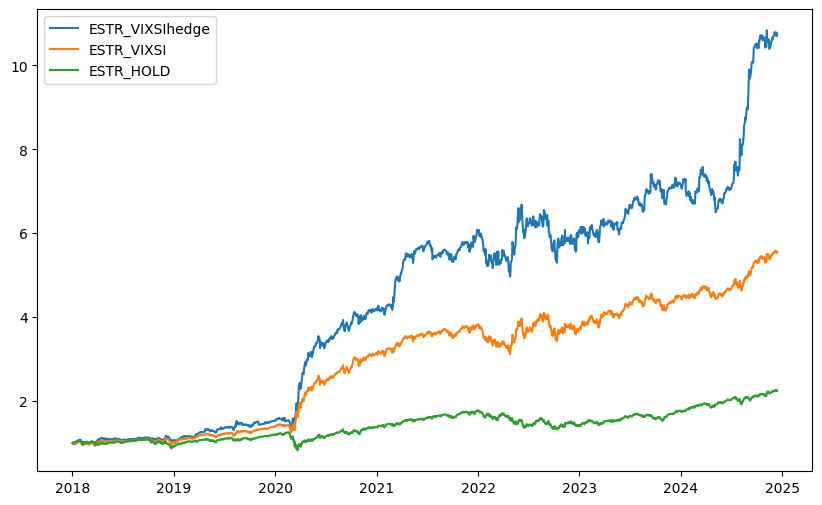

In [6]:
df_result, dic_activos_opt = wfo_vixsihedge (data, df_alpha, mejor_dalpha_rsh)
df_result

In [7]:
dic_activos_opt

{'2018': ['BK'],
 '2019': ['SLB'],
 '2020': ['TXN'],
 '2021': ['KLAC'],
 '2022': ['KLAC'],
 '2023': ['KLAC'],
 '2024': ['KLAC']}

### Conclusiones

Con la técnica WFO para la selección del activo hedge, añadiendo las heurísticas de dejar un periodo de un año entre optimización y test por la correlación negativa de los alphas relativos, y la selección del activo con mejor Beta, para obtener un mayor movimiento de cobertura, se ha encontrado un conjunto de activos en cada periodo de test, que globalmente generan una equity sensiblemente mejor que VIXSI.

En el siguiente sección se analizará la selección de activos hedge con estimación de los alphas relativos a partir de  modelos RNN.
